In [ ]:
!pip install pyarrow

In [ ]:
!pip3 install skimpy

# Анализ поездок такси

Исследование проведено с целью определения объёма недополученной общей выручки из-за низкого предложения.

Источник: data.cityofchicago.org. Этот набор данных предоставляет ценную информацию для анализа поездок такси, включая продолжительность, расстояние, оплату и географические координаты мест посадки и высадки. Его можно использовать для получения информации о моделях использования такси, распределении платы за проезд, популярных местах посадки/высадки и многом другом.

Этапы проекта:
> &nbsp;
> 1. Подготовка данные для анализа
> >  * Найти аномалии в данных, принять решение о их сохранении или отбрасывании
> 2. Рассчитать для каждого часа:
> >  * Количество машин на линии (только по данным начала поездок)
> >  * Количество поездок
> >  * Среднюю длительность поездки
> >  * Среднюю длинну поездки
> >  * Среднюю тарифную стоимость поездки
> >  * Иные показатели, включая показатели из расчёта на одного водителя, включая общую выручку и выручку водителя (исходя из того, что водитель получает 60% тарифа за поездку и все чаевые)
> 3. Определить периоды когда водители получают
> >  * выручку исходя из тарифа ниже среднего
> >  * меньше чаевых
> 4. Определите критические периоды дефицита предложения
> >  * рассчитайте оптимальное число машин на линии для обеспечения нормального показателя покрытия
> 5. Визуализировать найденные в п.4 и важные рассчитанные ранее показатели с учётом недельных и суточных циклов
>
> 6. Определить периоды, в которые меры стимулирования предложения услуг такси нужны и будут наиболее эффективны
>
> 7. В рамках определённых в п.6 периодов оценить:
> >  * объём недополученной общей выручки из-за низкого предложения
> >  * дефицит количества машин на линии (сколько нужно вывести машин дополнительно, чтобы достичь нормального покрытия)
> 8. (опционально) Предложите меры стимулирования предложения и оцените их эффективность
>
> 9. Подготовить презентацию на 7-10 слайдов с основными результатами проекта.
> &nbsp;<br><br>

Столбцы:

* Trip Start Timestamp: дата и время начала поездки
* Trip End Timestamp: дата и время окончания поездки
* Trip Seconds: продолжительность поездки в секундах
* Trip Miles: расстояние, пройденное во время поездки в милях
* Pickup Community Area: зона, где был подобран клиент
* Dropoff Community Area: зона, где был высажен клиент
* Fare: сумма тарифа, взимаемая за поездку в долларах
* Tips: сумма чаевых за поездку
* Tolls: сумма, уплачиваемая во время поездки (за платные дороги)
* Extras: Дополнительные сборы за поездку
* Trip Total: общая сумма оплаты за поездку
* Payment Type: Тип оплаты поездки
* Company: Компания такси, связанная с поездкой
* Pickup Centroid Latitude, Pickup Centroid Longitude, Dropoff Centroid Latitude, Dropoff Centroid Longitude: координаты центров кластеров посадки/высадки
* Taxi ID: Уникальный идентификатор такси

Этот набор данных предоставляет ценную информацию для анализа поездок такси, включая продолжительность, расстояние, оплату и географические координаты мест посадки и высадки. Его можно использовать для получения информации о моделях использования такси, распределении платы за проезд, популярных местах посадки/высадки и многом другом. Источник: data.cityofchicago.org

Столбцы:

* Hour Trip Start: час начала поездки
* Estimated coverage: расчётная величина покрытия машинами

Рассчитанная на основании данных доля уникальных клиентов в этот час, которым был предложен вариант поездки по запросу (даже если они не воспользовались услугой).

## Открытие данных

In [ ]:
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
from skimpy import clean_columns

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.options.display.max_rows = 50

In [ ]:
# URL файла в Google Drive
url = 'https://drive.google.com/file...'

# Извлечение идентификатора файла
file_id = url.split('/')[-2]

# Полный URL для загрузки файла
download_url = f'https://drive.google.com/uc?id={file_id}'

# Загрузка файла в текущую директорию с именем 'data.csv'
!gdown --id {file_id} -O Taxi_data.ftr

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pMmDJokQAAhjqVTGMEZrGlW1w0yvwD7R
To: /content/Taxi_data.ftr
100% 79.9M/79.9M [00:01<00:00, 73.7MB/s]


In [ ]:
# URL файла в Google Drive
url = 'https://drive.google.com/file...'

# Извлечение идентификатора файла
file_id = url.split('/')[-2]

# Полный URL для загрузки файла
download_url = f'https://drive.google.com/uc?id={file_id}'

# Загрузка файла в текущую директорию с именем 'data.csv'
!gdown --id {file_id} -O Estimated_coverage.ftr

In [ ]:
# загрузка файлов с данными
try:
    df = pd.read_feather('Taxi_data.ftr')
    df_cover = pd.read_feather('Estimated_coverage.ftr')
except:
    df = pd.read_feather('https://drive.google.com/file...')
    df_cover = pd.read_feather('https://drive.google.com...')


In [ ]:
#ознакомимся с общей инфомацией о первом полученном датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826887 entries, 0 to 1826886
Data columns (total 18 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip Start Timestamp        datetime64[ns]
 1   Trip End Timestamp          datetime64[ns]
 2   Trip Seconds                float64       
 3   Trip Miles                  float64       
 4   Pickup Community Area       float64       
 5   Dropoff Community Area      float64       
 6   Fare                        float64       
 7   Tips                        float64       
 8   Tolls                       float64       
 9   Extras                      float64       
 10  Trip Total                  float64       
 11  Payment Type                category      
 12  Company                     category      
 13  Pickup Centroid Latitude    float64       
 14  Pickup Centroid Longitude   float64       
 15  Dropoff Centroid Latitude   float64       
 16  Dropoff Centroid L

In [ ]:
#ознакомимся с общей инфомацией о втором полученном датафрейме
df_cover.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Hour Trip Start     1413 non-null   datetime64[ns]
 1   Estimated coverage  1411 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB


In [ ]:
#приведем названия столбцов к змеиному регистру
df = clean_columns(df)
df.columns.tolist()

['trip_start_timestamp',
 'trip_end_timestamp',
 'trip_seconds',
 'trip_miles',
 'pickup_community_area',
 'dropoff_community_area',
 'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'payment_type',
 'company',
 'pickup_centroid_latitude',
 'pickup_centroid_longitude',
 'dropoff_centroid_latitude',
 'dropoff_centroid_longitude',
 'taxi_id']

In [ ]:
#приведемназвания столбцов к змеиному регистру
df_cover = clean_columns(df_cover)
df_cover.columns.tolist()

['hour_trip_start', 'estimated_coverage']

In [ ]:
#ознакомся с первым датафреймом
df.head(5)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id
0,2015-02-06 06:45:00,2015-02-06 07:00:00,540.00,2.80,21.00,15.00,8.85,0.00,0.00,0.00,8.85,No Charge,Top Cab Affiliation,41.94,-87.71,41.95,-87.76,250
1,2015-02-13 20:30:00,2015-02-13 20:45:00,600.00,2.00,8.00,28.00,8.25,1.00,0.00,0.00,9.25,Credit Card,KOAM Taxi Association,41.89,-87.62,41.88,-87.66,1915
2,2015-03-11 23:30:00,2015-03-11 23:45:00,540.00,0.10,28.00,8.00,7.65,0.00,0.00,0.00,7.65,Cash,Taxi Affiliation Services,41.88,-87.64,41.89,-87.63,110
3,2015-03-13 22:15:00,2015-03-13 22:15:00,360.00,1.70,33.00,32.00,6.65,0.00,0.00,1.00,7.65,Credit Card,Choice Taxi Association,41.85,-87.62,41.87,-87.63,1802
4,2015-03-13 22:15:00,2015-03-13 22:15:00,0.00,0.00,NaN,NaN,40.85,8.17,0.00,0.00,49.02,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,3219


In [ ]:
#ознакомся со вторым датафреймом
df_cover.head(5)

,hour_trip_start,estimated_coverage
0,2015-02-01 00:00:00,0.36
1,2015-02-01 01:00:00,0.61
2,2015-02-01 02:00:00,0.74
3,2015-02-01 03:00:00,0.73
4,2015-02-01 04:00:00,0.79


In [ ]:
print('Интервал поездок с', df['trip_start_timestamp'].min(), 'по', df['trip_end_timestamp'].max(), \
     'общий период', (df['trip_end_timestamp'].max() - df['trip_start_timestamp'].min()).days, 'дней')

Интервал поездок с 2015-02-01 00:00:00 по 2015-03-31 23:45:00 общий период 58 дней


In [ ]:
print('Интервал поездок с', df_cover['hour_trip_start'].min(), 'по', df_cover['hour_trip_start'].max(), \
     'общий период', (df_cover['hour_trip_start'].max() - df_cover['hour_trip_start'].min()).days, 'дней')

Интервал поездок с 2015-02-01 00:00:00 по 2015-04-01 00:00:00 общий период 59 дней


In [ ]:
#Сохраним общее количество строк в дата фрейме до обработки
len_df_first = len(df)

## Обработка дубликатов

In [ ]:
#Проверим есть ли дубликаты
df.duplicated().sum()

1760

In [ ]:
#удалим явные дубликаты
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [ ]:
#Убедимся, что индексы в df соответствуют кол-ву строк
print(len(df) == (df.index.max()+1))

#Выведем % сохраненной информации от первоначальных данных
print(round(len(df)/len_df_first*100, 2))

True
99.9


Не все столбцы первого датафрейма необходимы для выполнения целей проекта. В частности, с геоданными в данном проекте работать не требуется.

In [ ]:
#Оставим в датафрейме только те столбцы, с которыми планируется дальнейшая работа
df = df[['trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'trip_miles', 'fare', 'tips', \
         'trip_total', 'taxi_id']]

## Обработка пропущенных значений

In [ ]:
df.isna().sum()

trip_start_timestamp     0
trip_end_timestamp       0
trip_seconds            16
trip_miles               4
fare                     2
tips                     2
trip_total               2
taxi_id                  0
dtype: int64

### Обработка пропущенных значений в столбце trip_seconds

Пропусков в столбце всего 16, можно попробовать их заполнить по значениям разницы между столбцами начала и окончания поездки. Однако, ознакомившись с датафреймом, появилось предположение, что данные в столбцах trip_start_timestamp и trip_end_timestamp округлены до 15 минут. Проверим так ли это.

In [ ]:
#Выведем уникальное количество минут в столбце trip_end_timestamp
pd.DatetimeIndex(df['trip_start_timestamp']).minute.unique()

Index([45, 30, 15, 0], dtype='int32', name='trip_start_timestamp')

In [ ]:
#Выведем уникальное количество минут в столбце trip_end_timestamp
pd.DatetimeIndex(df['trip_end_timestamp']).minute.unique()

Index([0, 45, 15, 30], dtype='int32', name='trip_end_timestamp')

Значения в столбцах trip_start_timestamp и trip_end_timestamp кратны 15 минутам.

In [ ]:
#посчиаем время поездки для сравнения с данными в столбце trip_seconds
df['trip_seconds_2'] = (df['trip_end_timestamp'] - df['trip_start_timestamp']).dt.seconds


In [ ]:
df[df['trip_seconds_2'] != df['trip_seconds']]

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,trip_seconds_2
0,2015-02-06 06:45:00,2015-02-06 07:00:00,540.00,2.80,8.85,0.00,8.85,250,900
1,2015-02-13 20:30:00,2015-02-13 20:45:00,600.00,2.00,8.25,1.00,9.25,1915,900
2,2015-03-11 23:30:00,2015-03-11 23:45:00,540.00,0.10,7.65,0.00,7.65,110,900
3,2015-03-13 22:15:00,2015-03-13 22:15:00,360.00,1.70,6.65,0.00,7.65,1802,0
5,2015-02-08 03:15:00,2015-02-08 03:30:00,540.00,2.60,9.05,0.00,10.55,1953,900
...,...,...,...,...,...,...,...,...,...
1825122,2015-03-22 00:30:00,2015-03-22 00:30:00,300.00,0.00,4.85,0.00,4.85,274,0
1825123,2015-03-15 10:00:00,2015-03-15 10:30:00,"2,040.00",0.00,47.25,17.55,87.80,407,1800
1825124,2015-03-21 17:15:00,2015-03-21 17:30:00,120.00,0.00,4.25,0.00,5.25,624,900
1825125,2015-03-15 10:00:00,2015-03-15 10:30:00,"1,320.00",20.70,40.45,7.00,50.45,810,1800


Выявлено более 1,5 миллионов строк в которых данные в trip_seconds не соответствуют данным расчетного столбца trip_seconds_2. Вероятно, данные в столбце trip_seconds являются фактическими, в то время, как trip_seconds_2 расчитывается исходя из округленных значений.
Достоверно заполнить пропуски разницей значений между столбцами trip_start_timestamp и trip_end_timestamp не получится.

In [ ]:
#Удалим строки с пропущенными значениями в столбце trip_seconds
df = df[~df['trip_seconds'].isna()].reset_index(drop= True)
df['trip_seconds'].isna().sum()

0

In [ ]:
#Убедимся, что индексы в df соответствуют кол-ву строк
print(len(df) == (df.index.max()+1))

#Выведем % сохраненной информации от первоначальных данных
print(round(len(df)/len_df_first*100, 2))

True
99.9


### Обработка пропущенных значений в столбце trip_miles

Ввиду того, что пропусков в столбце trip_miles всего 4, удалим эти данные так как это не повлияет на результат анализа.

In [ ]:
#ознакомимся со строками с пропусками в 'trip_miles'
df = df[~df['trip_miles'].isna()].reset_index(drop= True)

### Обработка пропущенных значений в столбце fare

Пропусков в столбце fare всего 2, ознакомимся с ними.

In [ ]:
#ознакомимся со строками с пропусками в 'fare'
df[df['fare'].isna()]

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,trip_seconds_2
1418651,2015-02-27 15:15:00,2015-02-27 15:15:00,0.00,15.50,NaN,NaN,NaN,1891,0
1579667,2015-03-27 12:45:00,2015-03-27 12:45:00,60.00,0.00,NaN,NaN,NaN,3610,0


Помимо пропусков в столбце fare, так же отсутсвует иная информация об оплате. Удалим эти поездки.  

In [ ]:
#удалим строки с пропусками в 'fare'
df = df[~df['fare'].isna()].reset_index(drop= True)

In [ ]:
#Убедимся, что индексы в df соответствуют кол-ву строк
len(df) == (df.index.max()+1)

True

In [ ]:
#Выведем % сохраненной информации от первоначальных данных
round(len(df)/len_df_first*100, 2)

99.9

## Обработка аномальных значений

### Обработка столбца 'taxi_id'

In [ ]:
print('Минимальное значение "taxi_id" -', df['taxi_id'].min())
print('Максимальное значение "taxi_id" -', df['taxi_id'].max())

Минимальное значение "taxi_id" - -1
Максимальное значение "taxi_id" - 4654


In [ ]:
#посчитаем количество значений taxi_id = -1
print('Количество значений taxi_id = "-1" -', len(df[df['taxi_id']== -1]))
print('Значений taxi_id = "-1" -', round(len(df[df['taxi_id']== -1])/len_df_first*100 , 5), '%')

Количество значений taxi_id = "-1" - 14
Значений taxi_id = "-1" - 0.00077 %


In [ ]:
#удалим строки со значениями -1 в taxi_id
df = df[df['taxi_id']!= -1].reset_index(drop= True)

In [ ]:
#Убедимся, что индексы в df соответствуют кол-ву строк
print(len(df) == (df.index.max()+1))

#Выведем % сохраненной информации от первоначальных данных
print(round(len(df)/len_df_first*100, 2))

True
99.9


### Обработка столбца 'trip_seconds'

In [ ]:
df['trip_seconds'].describe()

count   1,825,091.00
mean          666.58
std           679.56
min             0.00
25%           240.00
50%           480.00
75%           840.00
max        80,940.00
Name: trip_seconds, dtype: float64

In [ ]:
print('Количество нулевых значений в trip_seconds -', len(df[df['trip_seconds'] == 0]), 'что соответствует -',\
      round(len(df[df['trip_seconds'] == 0])/len_df_first * 100, 2), '%')

Количество нулевых значений в trip_seconds - 243427 что соответствует - 13.32 %


Более 13% от общего числа поездок, составили поездки с нулевыми значениями в trip_seconds. Вероятно, поздки были отменены, но за подачу машины была удержана плата.

-----------

Максимальное значение в столбце trip_seconds выглядит аномальным по сравнению со средним и медианным значениями. Ограничим значения в столбце trip_seconds размером экстремальных выбросов 3IQR

In [ ]:
#напишем функцию для определения экстремальных выбросов 3IQR
def removeOutliers(df, col):
    Q1 = np.quantile(df[col], 0.25)
    Q3 = np.quantile(df[col], 0.75)
    IQR = Q3 - Q1
    upper_range = Q3+3*IQR
    lower_range = (Q1-3*IQR).clip(0, None)

    print("Q1 %s: %s" % (col, Q1))
    print("Q3 %s: %s" % (col, Q3))
    print("IQR %s: %s" % (col, IQR))
    print("Верхняя граница экстремальных выбросов для %s: %s" % (col, upper_range))
    print("Нижняя граница экстремальных выбросов для %s: %s" % (col, lower_range))
    print('Количество отброшенных значений = ', len(df[(df[col] < lower_range) | (df[col] > upper_range)]))
    print('Процент отброшенных значений =',\
          round(100 - len(df[(df[col] >= lower_range) & (df[col] <= upper_range)])/ len(df[col]) * 100,2),'%')

    global filtered_data
    filtered_data = df[(df[col] >= lower_range) & (df[col] <= upper_range)]

In [ ]:
#Применим функцию removeOutliers к столбцу trip_seconds
removeOutliers(df, 'trip_seconds')

Q1 trip_seconds: 240.0
Q3 trip_seconds: 840.0
IQR trip_seconds: 600.0
Верхняя граница экстремальных выбросов для trip_seconds: 2640.0
Нижняя граница экстремальных выбросов для trip_seconds: 0.0
Количество отброшенных значений =  32853
Процент отброшенных значений = 1.8 %


In [ ]:
#Перезапишем датафрейм
df = filtered_data.reset_index(drop= True)

In [ ]:
#Убедимся, что индексы в df соответствуют кол-ву строк
print(len(df) == (df.index.max()+1))

#Выведем % сохраненной информации от первоначальных данных
print(round(len(df)/len_df_first*100, 2))

True
98.1


В столбце trip_seconds указано фактическое время поездки без учета округления до 15 минут, поэтому точность этих данных проверить не представляется возможным, однако, можно проверить на предмет ошибок находящихся за пределами 15 минутных округлений времени начала и окончания поездок.

In [ ]:
#созданим расчетные столбцы для определения времени поездок, измеряемом в количестве интервалов равным 15ти минутам
#столбца trip_seconds
df['trip_seconds_time_interval'] = round(df['trip_seconds']/60/15)

In [ ]:
#созданим расчетные столбцы для определения времени поездок, измеряемом в количестве интервалов равным 15ти минутам
#расчетного столбца trip_seconds_2
df['trip_seconds_2_time_interval'] = round(df['trip_seconds_2']/60/15)

In [ ]:
#посчитаем модуль разности интервалов
df['abc_time_interval'] = abs(df['trip_seconds_time_interval'] - df['trip_seconds_2_time_interval'])

In [ ]:
print(len(df[(df['abc_time_interval'] >1)]))
df[(df['abc_time_interval'] >1)].head()

229


,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,trip_seconds_2,trip_seconds_time_interval,trip_seconds_2_time_interval,abc_time_interval
642606,2015-03-08 01:45:00,2015-03-08 03:00:00,480.00,0.00,7.85,2.00,9.85,71,4500,1.00,5.00,4.00
677501,2015-03-08 01:30:00,2015-03-08 03:00:00,"1,260.00",7.70,18.65,0.00,19.65,756,5400,1.00,6.00,5.00
717085,2015-03-08 01:45:00,2015-03-08 03:00:00,540.00,3.90,10.65,0.00,10.65,378,4500,1.00,5.00,4.00
730559,2015-03-08 01:45:00,2015-03-08 03:00:00,540.00,0.00,7.65,1.00,9.65,618,4500,1.00,5.00,4.00
781104,2015-03-08 01:45:00,2015-03-08 03:00:00,600.00,0.10,8.05,0.00,9.05,715,4500,1.00,5.00,4.00


У 229 строк наблюдается несоответствие данных со временем начала и окончания поездки, даже с учетом округлений, с данным в столбце trip_seconds. В каких-то из столбцов допущена ошибка. Удалим эти строки.

In [ ]:
#Удалим строки, в которых данные со временем начала и окончания поездки, даже с учетом округлений,
#не соответсвуют данным в столбце trip_seconds
df = df[df['abc_time_interval'] <= 1].reset_index(drop= True)

#Удалим столбцы связанные с расчетом интервалов
df = df[['trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'trip_miles', 'fare', 'tips', \
         'trip_total', 'taxi_id']]

#
#df = df.query('trip_seconds < @trip_seconds_high').reset_index(drop= True)
#df.reset_index(drop= True, inplace= True)

In [ ]:
df['trip_seconds'].describe()

count   1,792,009.00
mean          614.29
std           526.95
min             0.00
25%           240.00
50%           480.00
75%           840.00
max         2,640.00
Name: trip_seconds, dtype: float64

In [ ]:
#Убедимся, что индексы в df соответствуют кол-ву строк
print(len(df) == (df.index.max()+1))

#Выведем % сохраненной информации от первоначальных данных
print(round(len(df)/len_df_first*100, 2))

True
98.09


Минимальное значение продолжительность поездки в секундах составляет 0, максимальное 2640. Среднее 614.29, медиана 480. В дальнейшем, при работе со столбцом trip_seconds необходимо учесть, что около 13% - это нулевые по продолительности поездки.

### Обработка столбца 'trip_total'

In [ ]:
df['trip_total'].describe()

count   1,792,009.00
mean           13.52
std            32.02
min             0.00
25%             6.85
50%             9.25
75%            14.20
max         9,449.33
Name: trip_total, dtype: float64

Наблюдается очень большой разброс в данных. Максимальное значение выглядит аномальным по сравнению со средним и медианным значениями.  

In [ ]:
print('Количество данных с нулевыми значениями в trip_total -', len(df[df['trip_total']==0]))
print('% данных с нулевыми значениями в trip_total -', round(len(df[df['trip_total']==0])/len_df_first*100, 2))

Количество данных с нулевыми значениями в trip_total - 1827
% данных с нулевыми значениями в trip_total - 0.1


In [ ]:
df[df['trip_total']==0].head(10)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id
3136,2015-02-03 09:45:00,2015-02-03 09:45:00,0.00,0.00,0.00,0.00,0.00,609
3898,2015-02-09 23:30:00,2015-02-09 23:30:00,0.00,0.00,0.00,0.00,0.00,758
4021,2015-02-13 19:45:00,2015-02-13 19:45:00,0.00,0.00,0.00,0.00,0.00,1
4812,2015-02-06 11:00:00,2015-02-06 11:00:00,0.00,0.00,0.00,0.00,0.00,82
5531,2015-02-08 00:30:00,2015-02-08 00:30:00,0.00,0.00,0.00,0.00,0.00,815
7052,2015-03-12 06:00:00,2015-03-12 06:00:00,60.00,0.00,0.00,0.00,0.00,2530
8097,2015-03-11 21:15:00,2015-03-11 21:15:00,0.00,0.00,0.00,0.00,0.00,3165
9412,2015-02-09 20:00:00,2015-02-09 20:00:00,480.00,0.00,0.00,0.00,0.00,1809
11922,2015-02-03 09:45:00,2015-02-03 09:45:00,0.00,0.00,0.00,0.00,0.00,25
15118,2015-02-04 08:00:00,2015-02-04 08:00:00,0.00,0.00,0.00,0.00,0.00,2354


Поездки с нулевыми значениями в trip_total не означают, что поездка не состоялась, возможно, что поездка была, но в данных допущены ошибки и оплата за поездку не была получена. Рассмотрим их подробнее.

In [ ]:
#выведем в отдельную таблицу информацию о нулевыех поездках
df_zero_trip = df[(df ['tips'] == 0) \
                  & (df['trip_seconds'] == 0) \
                  & (df['trip_total'] == 0) \
                  & (df['fare'] == 0)  \
                  & (df['trip_miles'] == 0)]

df_zero_trip

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id
3136,2015-02-03 09:45:00,2015-02-03 09:45:00,0.00,0.00,0.00,0.00,0.00,609
3898,2015-02-09 23:30:00,2015-02-09 23:30:00,0.00,0.00,0.00,0.00,0.00,758
4021,2015-02-13 19:45:00,2015-02-13 19:45:00,0.00,0.00,0.00,0.00,0.00,1
4812,2015-02-06 11:00:00,2015-02-06 11:00:00,0.00,0.00,0.00,0.00,0.00,82
5531,2015-02-08 00:30:00,2015-02-08 00:30:00,0.00,0.00,0.00,0.00,0.00,815
...,...,...,...,...,...,...,...,...
1784728,2015-03-24 07:15:00,2015-03-24 07:15:00,0.00,0.00,0.00,0.00,0.00,1905
1785013,2015-03-23 21:45:00,2015-03-23 21:45:00,0.00,0.00,0.00,0.00,0.00,1068
1786799,2015-02-26 18:15:00,2015-02-26 18:15:00,0.00,0.00,0.00,0.00,0.00,4092
1791419,2015-03-22 00:15:00,2015-03-22 00:15:00,0.00,0.00,0.00,0.00,0.00,2029


In [ ]:
print('Количество строк с полным отсутствием подтверждения о состоявшейся поездки -', len(df_zero_trip))

print('Поездок с полным отсутсвием подтверждения о состоявшейся поездки -', \
      round(len(df_zero_trip)/len_df_first*100 , 2), '%')

Количество строк с полным отсутствием подтверждения о состоявшейся поездки - 783
Поездок с полным отсутсвием подтверждения о состоявшейся поездки - 0.04 %


Выявлено 783 поездки с полным отсутсвием подтверждения о том, что подача машины была осуществлена. Удалим эти строки.

In [ ]:
#сохраним список индексов этих строк
d_z_t = list(df_zero_trip.index)
d_z_t

[3136,
 3898,
 4021,
 4812,
 5531,
 8097,
 11922,
 15118,
 15560,
 19391,
 22237,
 25289,
 28539,
 28829,
 28891,
 30472,
 31341,
 35985,
 36393,
 37016,
 37132,
 47907,
 49283,
 49858,
 54090,
 55194,
 55779,
 56497,
 59969,
 60052,
 62119,
 62352,
 63692,
 67276,
 70556,
 73574,
 77736,
 80155,
 81392,
 83502,
 84042,
 86757,
 88918,
 92930,
 94811,
 102225,
 102330,
 104846,
 105148,
 105900,
 107231,
 109080,
 110318,
 119530,
 120783,
 122404,
 125194,
 126673,
 127148,
 127970,
 128632,
 128810,
 129498,
 130567,
 134852,
 135087,
 138608,
 140937,
 141806,
 145882,
 153639,
 154406,
 155915,
 158902,
 160057,
 160258,
 161069,
 161550,
 169002,
 172349,
 175749,
 180893,
 181851,
 184395,
 191275,
 192236,
 197425,
 210091,
 213505,
 214155,
 215133,
 215567,
 216760,
 216811,
 221324,
 229062,
 229974,
 231087,
 231358,
 234055,
 236124,
 239925,
 249227,
 252333,
 252387,
 255248,
 256844,
 258661,
 263793,
 265404,
 266822,
 266928,
 267449,
 271583,
 272975,
 273185,
 274772

In [ ]:
#сверим, что строки совпадают
df_zero_trip.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id
3136,2015-02-03 09:45:00,2015-02-03 09:45:00,0.00,0.00,0.00,0.00,0.00,609
3898,2015-02-09 23:30:00,2015-02-09 23:30:00,0.00,0.00,0.00,0.00,0.00,758


In [ ]:
df.iloc[[3136, 3898]]

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id
3136,2015-02-03 09:45:00,2015-02-03 09:45:00,0.00,0.00,0.00,0.00,0.00,609
3898,2015-02-09 23:30:00,2015-02-09 23:30:00,0.00,0.00,0.00,0.00,0.00,758


In [ ]:
#Удалим строки
df = df.query('index != @d_z_t').reset_index(drop= True)
df.reset_index(drop= True, inplace= True)

In [ ]:
#убедимся, что нужные строки удалены
df.iloc[[3136, 3898]]

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id
3136,2015-02-06 11:00:00,2015-02-06 11:15:00,780.00,3.60,10.45,0.00,10.45,760
3898,2015-02-10 08:30:00,2015-02-10 08:30:00,240.00,0.00,5.05,0.00,5.05,159


In [ ]:
print('Количество нулевых значений в trip_total', len(df[df['trip_total'] == 0]))

Количество нулевых значений в trip_total 1044


Оставшиеся поездки с нулевыми значениями в trip_total оставим в датафрейме, поскольку нет подтверждений свидетельствовавших в пользу того, что они не состоялись, возможно, что машина была подана, но по каким-то причинам подача не была оплачена.

____

In [ ]:
#Применим функцию removeOutliers к столбцу trip_total
removeOutliers(df, 'trip_total')

Q1 trip_total: 6.85
Q3 trip_total: 14.2
IQR trip_total: 7.35
Верхняя граница экстремальных выбросов для trip_total: 36.25
Нижняя граница экстремальных выбросов для trip_total: 0.0
Количество отброшенных значений =  138585
Процент отброшенных значений = 7.74 %


Процент отброшенных значений достаточно значительный и для дальнейшего анализа требуется расчет количества транспортных средств и поездок, поэтому удаление этих строк вполне может отразится на результатах, в тоже время, верхнее экстремальное значение 36.25 не выглядит аномальным. В целях сохранения данных применим самостоятельный уровень выбросов верхней границы.

In [ ]:
#самостоятельно установим процент выбросов верхней границы.
hihg_percentele = 0.995
trip_total_high = df['trip_total'].quantile(hihg_percentele)

print(f'Верхняя граница trip_total {trip_total_high}')

print(
    'Процент отброшенных верхних значений = ',
    round(
        100 - len(df.query('trip_total <= @trip_total_high'))
        / len(df['trip_total']) * 100,
        2
    ),
    '%'
)
print(
    'Количество отброшенных верхних значений = ',
    len(df.query('trip_total > @trip_total_high')))

Верхняя граница trip_total 61.05
Процент отброшенных верхних значений =  0.5 %
Количество отброшенных верхних значений =  8940


In [ ]:
#Удалим строки
df = df.query('trip_total <= @trip_total_high')
df.reset_index(drop= True, inplace= True)

In [ ]:
#Получим новые данные описывающие trip_total
df['trip_total'].describe()

count   1,782,286.00
mean           13.03
std            10.56
min             0.00
25%             6.85
50%             9.25
75%            14.05
max            61.05
Name: trip_total, dtype: float64

In [ ]:
#Убедимся, что индексы в df соответствуют кол-ву строк
print(len(df) == (df.index.max()+1))

#Выведем % сохраненной информации от первоначальных данных
print(round(len(df)/len_df_first*100, 2))

True
97.56


Минимальное значение полной стоимости поездки составляет 0, максимальное 61.05. Среднее 13.03, медиана 9.25.

### Обработка столбца 'fare'

In [ ]:
df['fare'].describe()

count   1,782,286.00
mean           11.17
std             8.78
min             0.00
25%             5.85
50%             7.85
75%            12.25
max            61.05
Name: fare, dtype: float64

In [ ]:
print('Количество 0 в fare', len(df[df['fare'] == 0]))
print('Количество значений > 12,65 в fare', len(df[df['fare'] > 12.65]))

Количество 0 в fare 1133
Количество значений > 12,65 в fare 419284


In [ ]:
#Проверим соответствуют ли строки с нулевыми значениями в fare нулевым значениям в trip_total
#выведем количество поездок у которым нулевые значения не равны
len(df[(df['fare'] != 0) & (df['trip_total'] == 0)])

0

Аномальных значений не выявлено. Хотя значение 0 выглядит достаточно подозрительно, однако, ввиду их небольшого количества оставим их в датафреме.  Сумма тарифа, взимаемая за поездку в долларах составляет в среднем - 11.17, медиана - 7.85, минимальное значение - 0.00, максимальное - 61.05.

### Обработка столбца 'trip_miles'

In [ ]:
df['trip_miles'].describe()

count   1,782,286.00
mean            1.97
std             4.25
min             0.00
25%             0.00
50%             0.60
75%             1.90
max           835.20
Name: trip_miles, dtype: float64

Наблюдается очень большой разброс в данных. Максимальное значение выглядит аномальным по сравнению со средним и медианным значениями.  

In [ ]:
print('Количество нулевых значений в trip_miles -', len(df[df['trip_miles'] == 0]), 'что соответствует -',\
      round(len(df[df['trip_miles'] == 0])/len_df_first * 100, 2), '%')

Количество нулевых значений в trip_miles - 654020 что соответствует - 35.8 %


Проверим не округляются и значения trip_miles до 1 мили.

In [ ]:
#выведем уникальные значения и отсортируем их
sorted(round(df['trip_miles'], 2).unique())

[0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0,
 2.1,
 2.2,
 2.3,
 2.4,
 2.5,
 2.6,
 2.7,
 2.8,
 2.9,
 3.0,
 3.1,
 3.2,
 3.3,
 3.4,
 3.5,
 3.6,
 3.7,
 3.8,
 3.9,
 4.0,
 4.1,
 4.2,
 4.3,
 4.4,
 4.5,
 4.6,
 4.7,
 4.8,
 4.9,
 5.0,
 5.1,
 5.2,
 5.3,
 5.4,
 5.5,
 5.6,
 5.7,
 5.8,
 5.9,
 6.0,
 6.1,
 6.2,
 6.3,
 6.4,
 6.5,
 6.6,
 6.7,
 6.8,
 6.9,
 7.0,
 7.1,
 7.2,
 7.3,
 7.4,
 7.5,
 7.6,
 7.7,
 7.8,
 7.9,
 8.0,
 8.1,
 8.2,
 8.3,
 8.4,
 8.5,
 8.6,
 8.7,
 8.8,
 8.9,
 9.0,
 9.1,
 9.2,
 9.3,
 9.4,
 9.5,
 9.6,
 9.7,
 9.8,
 9.9,
 10.0,
 10.1,
 10.2,
 10.3,
 10.4,
 10.5,
 10.6,
 10.7,
 10.8,
 10.9,
 11.0,
 11.1,
 11.2,
 11.3,
 11.4,
 11.5,
 11.6,
 11.7,
 11.8,
 11.9,
 12.0,
 12.1,
 12.2,
 12.3,
 12.4,
 12.5,
 12.6,
 12.7,
 12.8,
 12.9,
 13.0,
 13.1,
 13.2,
 13.3,
 13.4,
 13.5,
 13.6,
 13.7,
 13.8,
 13.9,
 14.0,
 14.1,
 14.2,
 14.3,
 14.4,
 14.5,
 14.6,
 14.7,
 14.8,
 14.9,
 15.0,
 15.1,
 15.2,
 15.3,
 15.4,
 15.5,
 15.6,
 

Нулевых значений в trip_miles 36%, это выглядит странно, возможно, имеет место техническая ошибка. Предположение, что значения в столбце trip_miles округляются до 1 не подтвердилось. Рассмотрим описание данных trip_miles без учета нулевых значений

In [ ]:
#создадим временную таблицу исключив нулевые значения в trip_miles и trip_seconds
mnb = df[(df['trip_miles']!=0)& (df['trip_seconds']!=0)]
#выведем описание данных
mnb['trip_miles'].describe()

count   1,125,584.00
mean            3.12
std             4.85
min             0.10
25%             0.70
50%             1.40
75%             3.30
max           762.40
Name: trip_miles, dtype: float64

Без учета нулевых значений в trip_miles и trip_seconds максимальное значение всё-равно выглядит аномальным.
Рассмотрим сколько времени водители тратят на проезд 1 мили без учета нулевых значений

In [ ]:
mnb['trip_sec'] = round((mnb['trip_seconds']/60)/mnb['trip_miles'], 2)
mnb['trip_sec'].describe()

count   1,125,584.00
mean           17.86
std            33.45
min             0.00
25%             3.64
50%             5.38
75%             8.46
max           440.00
Name: trip_sec, dtype: float64

Выявлены аномальные значения 0 и 440 минут, которые тратят водители на проезд 1 мили.

In [ ]:
#самостоятельно установим процент выбросов
low_percentele = 0.00152
high_percentele = 0.99

trip_sec_low = mnb['trip_sec'].quantile(low_percentele)
trip_sec_high = mnb['trip_sec'].quantile(high_percentele)

print(f'Нижняя граница trip_sec {trip_sec_low}')
print(f'Верхняя граница trip_sec {trip_sec_high}')


Нижняя граница trip_sec 0.99
Верхняя граница trip_sec 150.0


Определили, что для поездок без нулевых значений в trip_miles и trip_seconds, минимальное количество времени, которое водитель тратит на проезд 1 мили - 1 минута, максимальное количество - 150 минут.  

In [ ]:
#Восстановим первоначальную таблицу вернув нулевые значения trip_seconds
mnb = df[(df['trip_miles']!=0)]
mnb['trip_sec'] = round((mnb['trip_seconds']/60)/mnb['trip_miles'], 2)
df['trip_sec'] = round((df['trip_seconds']/60)/df['trip_miles'], 2)

In [ ]:
print(
    'Процент отброшенных значений = ',
    round(
        100 - len(df.query('@trip_sec_low <= trip_total <= @trip_sec_high'))
        / len_df_first * 100,
        2
    ),
    '%'
)
print(
    'Количество отброшенных значений = ',
    len(mnb) - len(mnb.query('@trip_sec_low <= trip_sec <= @trip_sec_high')))

Процент отброшенных значений =  2.53 %
Количество отброшенных значений =  14759


In [ ]:
#Ознакомимся с этими поездками
mnb = mnb.query('@trip_sec_low > trip_sec |  trip_sec > @trip_sec_high')
mnb

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,trip_sec
109,2015-03-13 21:15:00,2015-03-13 21:15:00,0.00,0.50,4.05,0.00,4.05,54,0.00
239,2015-02-09 19:30:00,2015-02-09 19:30:00,0.00,0.20,3.25,0.00,3.25,1194,0.00
401,2015-02-06 11:15:00,2015-02-06 11:30:00,720.00,19.80,39.25,0.00,40.25,1126,0.61
413,2015-02-06 09:15:00,2015-02-06 09:30:00,"1,140.00",0.10,11.25,2.80,14.05,1385,190.00
526,2015-02-13 22:30:00,2015-02-13 22:45:00,"1,080.00",0.10,11.05,0.00,12.05,1174,180.00
...,...,...,...,...,...,...,...,...,...
1781174,2015-02-26 12:15:00,2015-02-26 12:45:00,"1,920.00",0.20,16.85,5.05,21.90,130,160.00
1781269,2015-02-26 18:15:00,2015-02-26 18:30:00,"1,020.00",0.10,11.05,0.00,12.05,1313,170.00
1781327,2015-02-26 18:30:00,2015-02-26 19:00:00,"1,740.00",0.10,15.45,5.00,20.45,1927,290.00
1781354,2015-02-26 17:00:00,2015-02-26 17:30:00,"1,860.00",0.20,16.45,0.00,16.45,912,155.00


In [ ]:
#сохраним список индексов
mnb_v = list(mnb.index)
mnb_v

[109,
 239,
 401,
 413,
 526,
 599,
 701,
 762,
 785,
 814,
 1060,
 1094,
 1452,
 1609,
 2114,
 2119,
 2381,
 2650,
 3116,
 3596,
 3784,
 3815,
 3964,
 4135,
 4317,
 4464,
 4578,
 4688,
 4908,
 5401,
 5451,
 5965,
 6236,
 6316,
 6327,
 6328,
 6717,
 6936,
 6946,
 7084,
 7415,
 7451,
 7806,
 7830,
 7921,
 7943,
 7987,
 8110,
 8115,
 8173,
 8344,
 8348,
 8400,
 8689,
 8730,
 9098,
 9111,
 9417,
 9499,
 9678,
 9843,
 9855,
 9858,
 9912,
 9974,
 10119,
 10137,
 10262,
 10269,
 10697,
 10732,
 10929,
 10995,
 11078,
 11159,
 11203,
 11545,
 11620,
 11687,
 11966,
 12260,
 12359,
 12566,
 12683,
 12909,
 12919,
 12934,
 13043,
 13157,
 13258,
 13300,
 13402,
 13491,
 13575,
 13762,
 13894,
 14161,
 14209,
 14327,
 14518,
 14625,
 14635,
 14652,
 14835,
 14874,
 14884,
 15107,
 15169,
 15220,
 15308,
 15721,
 15893,
 15924,
 16302,
 16406,
 16411,
 16453,
 16672,
 16682,
 16737,
 16741,
 16816,
 16891,
 17155,
 17372,
 17405,
 17541,
 17592,
 17659,
 17687,
 17765,
 17975,
 17987,
 18772,
 18

In [ ]:
#сверим, что строки совпадают
mnb.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,trip_sec
109,2015-03-13 21:15:00,2015-03-13 21:15:00,0.00,0.50,4.05,0.00,4.05,54,0.00
239,2015-02-09 19:30:00,2015-02-09 19:30:00,0.00,0.20,3.25,0.00,3.25,1194,0.00


In [ ]:
df.iloc[[110, 242]]

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,trip_sec
110,2015-02-07 21:45:00,2015-02-07 21:45:00,420.00,0.00,6.45,2.00,8.45,2111,inf
242,2015-02-08 03:15:00,2015-02-08 03:30:00,720.00,2.70,9.65,2.00,13.65,213,4.44


In [ ]:
#Сохраним количество строк до удаления
delete = len(df)

In [ ]:
#Удалим строки
df = df.query('index != @mnb_v').reset_index(drop= True)
df.reset_index(drop= True, inplace= True)

In [ ]:
#убедимся, что нужные строки удалены
df.iloc[[110, 242]]

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,trip_sec
110,2015-02-05 08:45:00,2015-02-05 08:45:00,0.00,0.00,6.65,1.33,7.98,2943,NaN
242,2015-02-05 01:15:00,2015-02-05 01:45:00,"1,380.00",17.50,35.25,0.00,39.75,239,1.31


In [ ]:
#Проверим корректность удаления
delete - len(df) == len(mnb_v)

True

In [ ]:
#удалим временный столбец trip_sec
df = df.drop(columns = df.columns[8], axis =1)
#Выведем таблицу после внесения изменений отсортированную по количеству миль
df.sort_values(by='trip_miles', ascending = False)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id
1035848,2015-02-18 19:30:00,2015-02-18 20:15:00,"2,580.00",42.20,38.05,10.00,50.05,977
1095846,2015-03-08 18:30:00,2015-03-08 19:15:00,"2,580.00",40.80,31.65,6.70,40.35,1685
1233526,2015-03-03 22:00:00,2015-03-03 22:45:00,"2,460.00",40.40,44.25,0.00,46.25,2627
52586,2015-02-12 20:45:00,2015-02-12 21:30:00,"2,640.00",40.00,31.85,7.15,43.00,1707
791583,2015-03-09 20:00:00,2015-03-09 20:30:00,"2,400.00",39.90,37.45,7.85,47.30,1481
...,...,...,...,...,...,...,...,...
1312529,2015-03-22 09:15:00,2015-03-22 09:15:00,0.00,0.00,30.05,0.00,30.05,2956
819072,2015-02-11 19:00:00,2015-02-11 19:00:00,0.00,0.00,9.45,0.00,9.45,3460
1312531,2015-03-29 11:30:00,2015-03-29 11:30:00,0.00,0.00,3.25,0.00,3.25,1657
819071,2015-02-18 16:15:00,2015-02-18 16:15:00,0.00,0.00,8.65,0.00,8.65,2732


In [ ]:
df['trip_miles'].describe()

count   1,767,527.00
mean            1.96
std             3.74
min             0.00
25%             0.00
50%             0.60
75%             1.90
max            42.20
Name: trip_miles, dtype: float64

На поездку приходится в среднем - 1.96 миля, медиана - 0.6, минимальное значение - 0.00, максимальное значение - 42.2.

In [ ]:
#Убедимся, что индексы в df соответствуют кол-ву строк
print(len(df) == (df.index.max()+1))

#Выведем % сохраненной информации от первоначальных данных
print(round(len(df)/len_df_first*100, 2))

True
96.75


In [ ]:
print('Количество нулевых значений в trip_miles -', len(df[df['trip_miles'] == 0]), 'что соответствует -',\
      round(len(df[df['trip_miles'] == 0])/len_df_first * 100, 2), '%')

Количество нулевых значений в trip_miles - 654020 что соответствует - 35.8 %


В дальнейшем, при работе со столбцом trip_miles необходимо учесть, что около 35.8% - это нулевые по растоянию поездки.

### Обработка столбца 'tips'

In [ ]:
df['tips'].describe()

count   1,767,527.00
mean            1.27
std             2.07
min             0.00
25%             0.00
50%             0.00
75%             2.00
max            56.75
Name: tips, dtype: float64

In [ ]:
print('Количество нулевых значений в tips -', len(df[df['tips'] == 0]), 'что соответствует -',\
      round(len(df[df['tips'] == 0])/len_df_first * 100, 2), '%')

Количество нулевых значений в tips - 1029559 что соответствует - 56.36 %


In [ ]:
#Применим функцию removeOutliers к столбцу tips
removeOutliers(df, 'tips')

Q1 tips: 0.0
Q3 tips: 2.0
IQR tips: 2.0
Верхняя граница экстремальных выбросов для tips: 8.0
Нижняя граница экстремальных выбросов для tips: 0.0
Количество отброшенных значений =  28311
Процент отброшенных значений = 1.6 %


Ошибок в значениях не выявлено, в 56.36% поездок водители не получают чаевые. В 1.6% поездок водители получают чаевые более 8 долларов.

In [ ]:
len(df)

1767527

## Анализ данных

### Объединение данных

Чтобы объединить таблицы df и df_cover округлим значения столбца trip_start_timestamp до 1 часа

In [ ]:
#Округим значения столбца trip_start_timestamp до часа
df['hour_trip_start'] = df['trip_start_timestamp'].dt.floor('1H')

#Преобразуем таблицу, удалив столбцы trip_start_timestamp и trip_end_timestamp
df = df[['hour_trip_start', 'trip_seconds', 'trip_miles', 'fare', 'tips', 'trip_total', 'taxi_id']]
df.head(5)

,hour_trip_start,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id
0,2015-02-06 06:00:00,540.00,2.80,8.85,0.00,8.85,250
1,2015-02-13 20:00:00,600.00,2.00,8.25,1.00,9.25,1915
2,2015-03-11 23:00:00,540.00,0.10,7.65,0.00,7.65,110
3,2015-03-13 22:00:00,360.00,1.70,6.65,0.00,7.65,1802
4,2015-03-13 22:00:00,0.00,0.00,40.85,8.17,49.02,3219


In [ ]:
df_cover.head()

,hour_trip_start,estimated_coverage
0,2015-02-01 00:00:00,0.36
1,2015-02-01 01:00:00,0.61
2,2015-02-01 02:00:00,0.74
3,2015-02-01 03:00:00,0.73
4,2015-02-01 04:00:00,0.79


In [ ]:
df = df.merge(df_cover, on='hour_trip_start', how= 'inner')
df.head()

,hour_trip_start,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,estimated_coverage
0,2015-02-06 06:00:00,540.00,2.80,8.85,0.00,8.85,250,0.75
1,2015-02-06 06:00:00,0.00,0.00,3.25,40.00,43.25,117,0.75
2,2015-02-06 06:00:00,"1,320.00",0.00,27.85,10.00,39.85,633,0.75
3,2015-02-06 06:00:00,480.00,2.40,8.05,0.00,8.05,2043,0.75
4,2015-02-06 06:00:00,540.00,0.10,9.25,0.00,9.25,480,0.75


In [ ]:
#выведем информцию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1767527 entries, 0 to 1767526
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   hour_trip_start     datetime64[ns]
 1   trip_seconds        float64       
 2   trip_miles          float64       
 3   fare                float64       
 4   tips                float64       
 5   trip_total          float64       
 6   taxi_id             int32         
 7   estimated_coverage  float64       
dtypes: datetime64[ns](1), float64(6), int32(1)
memory usage: 101.1 MB


В столбце estimated_coverage выявили 3 пропущенных значения

In [ ]:
df[df['estimated_coverage'].isna()]

,hour_trip_start,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,estimated_coverage
973517,2015-03-25 06:00:00,"1,320.00",1.00,34.65,9.15,45.80,2709,NaN
973518,2015-03-25 06:00:00,300.00,0.00,5.65,0.00,5.65,2709,NaN
973519,2015-03-25 06:00:00,"1,260.00",12.70,27.25,0.00,29.25,543,NaN


In [ ]:
#Проверим есть ли данные за этот период в датафреме
df[df['hour_trip_start']== '2015-03-25 06:00:00']

,hour_trip_start,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,estimated_coverage
973517,2015-03-25 06:00:00,"1,320.00",1.00,34.65,9.15,45.80,2709,NaN
973518,2015-03-25 06:00:00,300.00,0.00,5.65,0.00,5.65,2709,NaN
973519,2015-03-25 06:00:00,"1,260.00",12.70,27.25,0.00,29.25,543,NaN


In [ ]:
#Выведем описание данных столбца estimated_coverage
df['estimated_coverage'].describe()

count   1,767,524.00
mean            0.73
std             0.03
min             0.00
25%             0.71
50%             0.73
75%             0.75
max             1.00
Name: estimated_coverage, dtype: float64

Есть выбивающееся значение 0, ознакомимся с этими периодами.

In [ ]:
df[df['estimated_coverage'] == 0]

,hour_trip_start,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,estimated_coverage
1730153,2015-03-17 01:00:00,"1,020.00",0.40,17.45,4.60,23.05,13,0.00
1730154,2015-03-17 01:00:00,360.00,0.10,6.85,0.00,6.85,13,0.00
1730155,2015-03-17 01:00:00,"1,260.00",9.60,21.25,0.00,23.25,1145,0.00
1730156,2015-03-17 01:00:00,"1,020.00",0.20,13.05,2.60,15.65,159,0.00
1730157,2015-03-17 01:00:00,240.00,0.00,5.05,1.00,7.05,159,0.00


In [ ]:
#Проверим есть ли данные за этот период в датафреме
df[df['hour_trip_start']== '2015-03-17 01:00:00']

,hour_trip_start,trip_seconds,trip_miles,fare,tips,trip_total,taxi_id,estimated_coverage
1730153,2015-03-17 01:00:00,"1,020.00",0.40,17.45,4.60,23.05,13,0.00
1730154,2015-03-17 01:00:00,360.00,0.10,6.85,0.00,6.85,13,0.00
1730155,2015-03-17 01:00:00,"1,260.00",9.60,21.25,0.00,23.25,1145,0.00
1730156,2015-03-17 01:00:00,"1,020.00",0.20,13.05,2.60,15.65,159,0.00
1730157,2015-03-17 01:00:00,240.00,0.00,5.05,1.00,7.05,159,0.00


Заполнять данные средними значениями по всему датасету некорректно. Удалить такие строки - их у нас очень мало, как и строки где покрытие не было определено.

In [ ]:
len(df)

1767527

In [ ]:
df = df[(~df['estimated_coverage'].isna()) & (df['estimated_coverage'] != 0)]
len(df)

1767519

Посмотрим какие месяцы присутствуют в анализе данных

In [ ]:
df['month'] = df['hour_trip_start'].dt.month
df['month'].unique()

array([2, 3], dtype=int32)

In [ ]:
df.groupby('month')['month'].count()

month
2    814727
3    952792
Name: month, dtype: int64

In [ ]:
print('минимальная дата df - ', df['hour_trip_start'].min(), ', максимальная дата  df- ', \
      df['hour_trip_start'].max())

минимальная дата df -  2015-02-01 00:00:00 , максимальная дата  df-  2015-03-31 23:00:00


In [ ]:
print('Интервал поездок с', df['hour_trip_start'].min(), 'по', df['hour_trip_start'].max(), \
     'общий период', (df['hour_trip_start'].max() - df['hour_trip_start'].min()).days, 'дней')

Интервал поездок с 2015-02-01 00:00:00 по 2015-03-31 23:00:00 общий период 58 дней


Добавим новые столбцы с часом, днем недели и месяцем поездки.

In [ ]:
df['hour'] = df['hour_trip_start'].dt.hour
sorted(df['hour'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [ ]:
df['weekday'] = df['hour_trip_start'].dt.weekday+1
sorted(df['weekday'].unique())

[1, 2, 3, 4, 5, 6, 7]

### Расчет дополнительных данных
    • Количество машин на линии (только по данным начала поездок)  для каждого часа
    • Количество поездок  для каждого часа
    • Среднюю длительность поездки для каждого часа
    • Среднюю длинну поездки для каждого часа
    • Среднюю тарифную стоимость поездки для каждого часа

In [ ]:
data_pivot_hour = df.groupby('hour_trip_start').agg({'taxi_id':['nunique','count'], 'trip_seconds':'median',\
                                   'trip_miles':'median', 'fare':'mean'})
data_pivot_hour.columns = ['taxi_id_count', 'trip_count', 'trip_seconds_median', 'trip_miles_median', \
                          'fare_mean']
data_pivot_hour

,taxi_id_count,trip_count,trip_seconds_median,trip_miles_median,fare_mean
hour_trip_start,,,,,
2015-02-01 00:00:00,6,10,660.00,0.10,13.17
2015-02-01 01:00:00,7,15,540.00,0.90,10.42
2015-02-01 02:00:00,838,1193,480.00,0.50,9.14
2015-02-01 03:00:00,979,2006,420.00,0.60,9.10
2015-02-01 04:00:00,454,592,420.00,0.70,9.92
...,...,...,...,...,...
2015-03-31 19:00:00,801,1019,480.00,0.70,10.51
2015-03-31 20:00:00,865,1147,480.00,0.70,11.30
2015-03-31 21:00:00,6,15,420.00,0.80,12.16


### 	Расчет данных по водителям
     •	Средняя сумма выручки по тарифу по водителям
     •	Средняя сумма чаевых по водителям

In [ ]:
data_pivot_taxi_id = df.groupby('taxi_id').agg({'fare': 'mean', 'tips':'mean'})
data_pivot_taxi_id.columns = ['taxi_id_fare_mean', 'taxi_id_tips_mean']
data_pivot_taxi_id

,taxi_id_fare_mean,taxi_id_tips_mean
taxi_id,,
1,9.88,0.86
2,9.58,1.03
3,9.71,0.42
4,8.93,0.64
5,9.50,0.84
...,...,...
4650,40.00,0.00
4651,26.40,0.00
4652,30.00,7.50


#####  •	Cумма выручки по водителям -  60% от тарифа

In [ ]:
data_pivot_taxi_id['taxi_id_fare_60%_mean'] = round(data_pivot_taxi_id['taxi_id_fare_mean']*0.6, 2)

#####  •	Сумма выручки по водителям -  60%  и чаевые от тарифа

In [ ]:
data_pivot_taxi_id['taxi_id_fare_60%_mean_tips'] = data_pivot_taxi_id['taxi_id_fare_60%_mean'] \
                                                + data_pivot_taxi_id['taxi_id_tips_mean']

#####  •	Сумма выручки провайдера по водителям за вычетом 60% дохода водителя

In [ ]:
data_pivot_taxi_id['provider_fare'] = data_pivot_taxi_id['taxi_id_fare_mean'] \
                                - data_pivot_taxi_id['taxi_id_fare_60%_mean']

In [ ]:
df['60f+t'] = round(df['fare']*0.6, 2)+  df['tips']

In [ ]:
taxi_id_trip = df.merge(data_pivot_taxi_id, on= 'taxi_id', how='outer')
taxi_id_trip = data_pivot_hour.merge(taxi_id_trip, on= 'hour_trip_start', how='outer')
taxi_id_trip= taxi_id_trip[['hour_trip_start', 'month', 'weekday', 'hour',\
                            'taxi_id', 'trip_total','fare','fare_mean',\
                            'taxi_id_fare_mean', 'taxi_id_fare_60%_mean', \
                            'tips','taxi_id_tips_mean','taxi_id_fare_60%_mean_tips','60f+t',\
                            'provider_fare','estimated_coverage', 'taxi_id_count', 'trip_count']]
taxi_id_trip.sort_values(by='taxi_id')

,hour_trip_start,month,weekday,hour,taxi_id,trip_total,fare,fare_mean,taxi_id_fare_mean,taxi_id_fare_60%_mean,tips,taxi_id_tips_mean,taxi_id_fare_60%_mean_tips,60f+t,provider_fare,estimated_coverage,taxi_id_count,trip_count
653911,2015-02-24 14:00:00,2,2,14,1,6.05,6.05,10.28,9.88,5.93,0.00,0.86,6.79,3.63,3.95,0.72,1347,2539
45027,2015-02-05 08:00:00,2,4,8,1,22.85,22.85,8.81,9.88,5.93,0.00,0.86,6.79,13.71,3.95,0.76,796,1657
1722021,2015-03-29 08:00:00,3,7,8,1,8.45,7.45,15.08,9.88,5.93,0.00,0.86,6.79,4.47,3.95,0.77,515,758
1240293,2015-03-14 00:00:00,3,6,0,1,17.05,13.65,10.33,9.88,5.93,3.40,0.86,6.79,11.59,3.95,0.75,1292,2235
178207,2015-02-10 00:00:00,2,2,0,1,8.65,8.65,12.23,9.88,5.93,0.00,0.86,6.79,5.19,3.95,0.73,423,545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395703,2015-03-18 15:00:00,3,3,15,4650,40.00,40.00,12.31,40.00,24.00,0.00,0.00,24.00,24.00,16.00,0.70,1131,1627
225738,2015-02-11 23:00:00,2,3,23,4651,26.40,26.40,11.18,26.40,15.84,0.00,0.00,15.84,15.84,10.56,0.74,965,1804
241102,2015-02-12 11:00:00,2,4,11,4652,37.50,30.00,10.47,30.00,18.00,7.50,7.50,25.50,25.50,12.00,0.71,1314,2243
984556,2015-03-06 08:00:00,3,5,8,4653,18.92,16.45,10.09,16.45,9.87,2.47,2.47,12.34,12.34,6.58,0.75,1013,2200


#### Определим периоды когда водители получают:
-	выручку исходя из тарифа ниже среднего
-	меньше чаевых


In [ ]:
# Определим средний доход водителей (тариф 60% + чаевые)
taxi_id_trip['60f'] = round(taxi_id_trip['fare']*0.6, 2)
trip_fare_mean_ = round(taxi_id_trip['60f'].mean(), 2)
print('Cредний доход водителей тариф 60% -', trip_fare_mean_, '$')

Cредний доход водителей тариф 60% - 6.7 $


In [ ]:
# Определим средние чаевые
trip_tips_mean = round(taxi_id_trip['tips'].mean(), 2)
print('Cредние чаевые -', trip_tips_mean, '$')

Cредние чаевые - 1.27 $


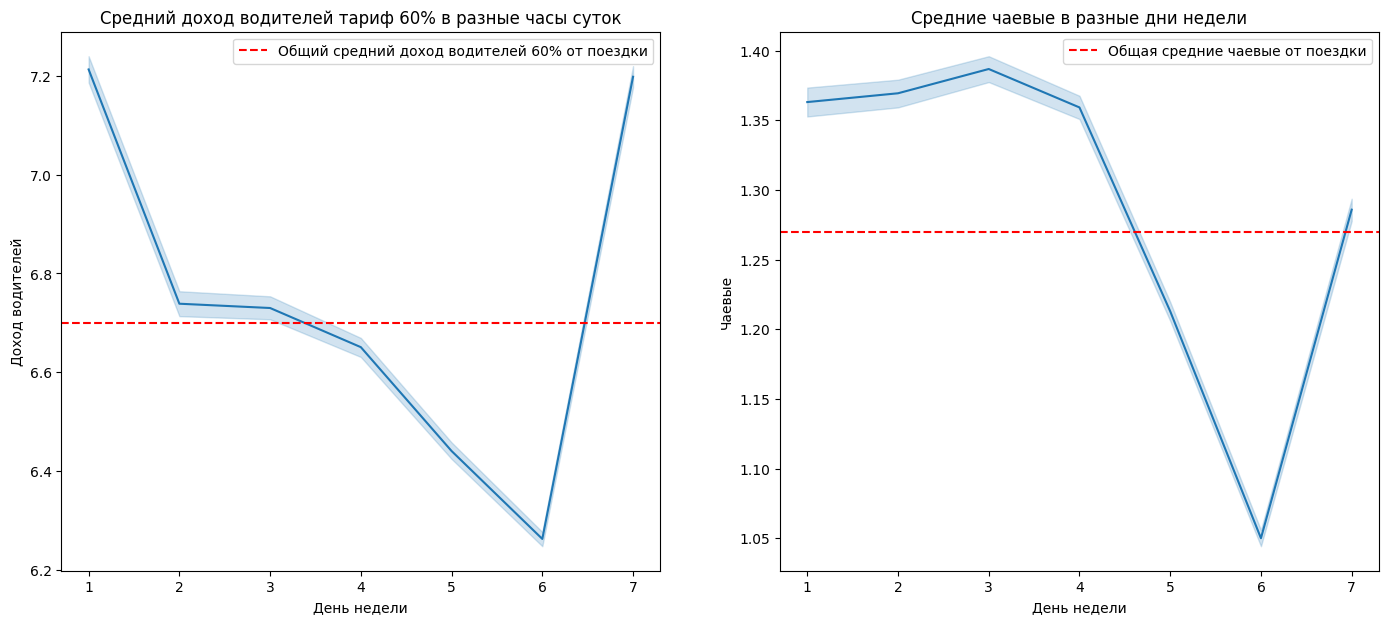

In [ ]:
#Визуализируем периоды, когда средний доход водителей (тариф 60%) и средние чаевые по дням недели
#ниже общего среднего уровня.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 7))#hue='month',

sns.lineplot(x='weekday', y='60f', data=taxi_id_trip, palette ="pastel", ax=ax1, estimator='mean')
ax1.axhline(trip_fare_mean_, color='red',linestyle='--',label='Общий средний доход водителей 60% от поездки')
ax1.legend()
ax1.set_title('Средний доход водителей тариф 60% в разные часы суток')
ax1.set_xlabel('День недели')
ax1.set_ylabel('Доход водителей')

sns.lineplot(x='weekday', y='tips', data=taxi_id_trip, palette ="pastel", ax=ax2, \
             estimator='mean')
ax2.axhline(trip_tips_mean, color='red',linestyle='--',label='Общая средние чаевые от поездки')
ax2.legend()
ax2.set_title('Средние чаевые в разные дни недели')
ax2.set_xlabel('День недели')
ax2.set_ylabel('Чаевые')

plt.show()

Максимальный доход у водителей отмечается в понедельник. Со вторника по четверг доход находится чуть выше на среднего уровня. В субботу отмечается резкое снижение уровня дохода. В воскресенье Уровень дохода вновь выше среднего.

Чаевые не дублируют кривую дохода водителей. Стоит отметить, что чаевые держатся на равномерно высоком уровне с понедельника по четверг, в отличае от дохода водителей. В пятницу и воскресенье чаевые ниже среднего, в субботу наименьший уровень чаевых.

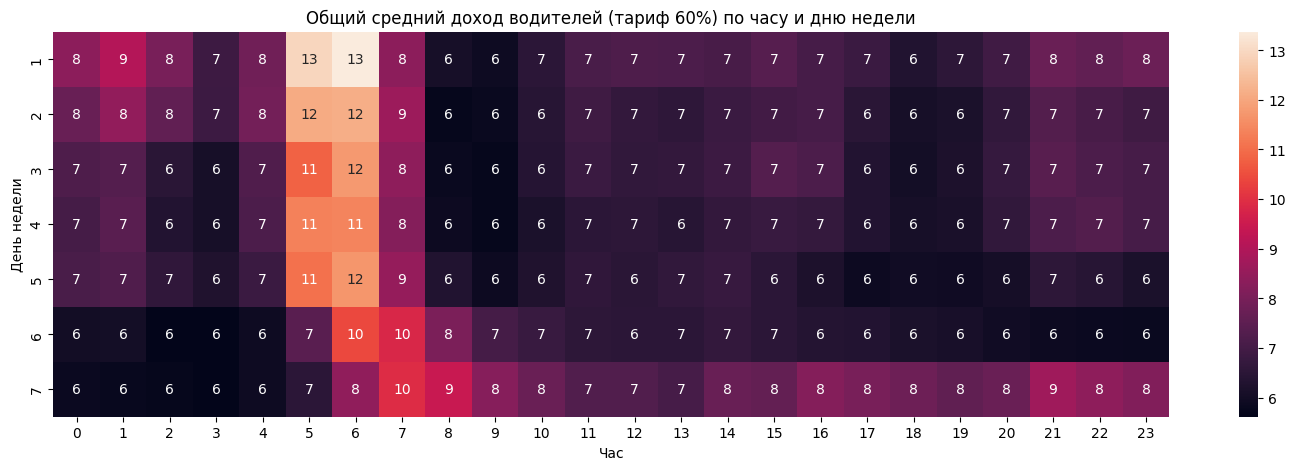

In [ ]:
#Визуализируем общий средний доход водителей (тариф 60%) по часу и дню недели
plt.figure(figsize=(18,5))
sns.heatmap(pd.pivot_table(data=taxi_id_trip,index = 'weekday' ,columns='hour',values='60f',aggfunc='mean'), \
            annot=True, fmt=".0f")
plt.title('Общий средний доход водителей (тариф 60%) по часу и дню недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

В будние дни с 0 до 4 часов утра доход водителей ниже среднего уровня. В период с 5 до 7 часов утра доход водителей значительно выше среднего, с 8 утра и до 23 часов доход водителей приблизительно равномерный и находится на среднем уровне.

В субботу с 0 до 5ти часов утра отмечается равномерно низкий доход водителей. В период с 6 до 8 часов утра доход водителей значительно выше среднего, с 9 утра и до 23 часов доход водителей вновь равномерно низкий.
В будние дни с 0 до 4 часов утра доход водителей ниже среднего уровня.

В воскресень с 0 до 6ти часов утра отмечается равномерно низкий доход водителей. В период с 7 до 8 часов утра доход водителей значительно выше среднего, с 9 утра и до 23 часов доход водителей приблизительно равномерный - выше среднего.

Наблюдается равномерное соотношение данных по часам в будние дни. Для графика объединим в общую кривую будние дни.

In [ ]:
taxi_id_trip['weekends'] = taxi_id_trip['weekday']
taxi_id_trip['weekends'] = taxi_id_trip['weekends'].replace([1,2,3,4,5], 'weekdays')
taxi_id_trip['weekends'] = taxi_id_trip['weekends'].replace(6, 'saturday')
taxi_id_trip['weekends'] = taxi_id_trip['weekends'].replace(7, 'sunday')

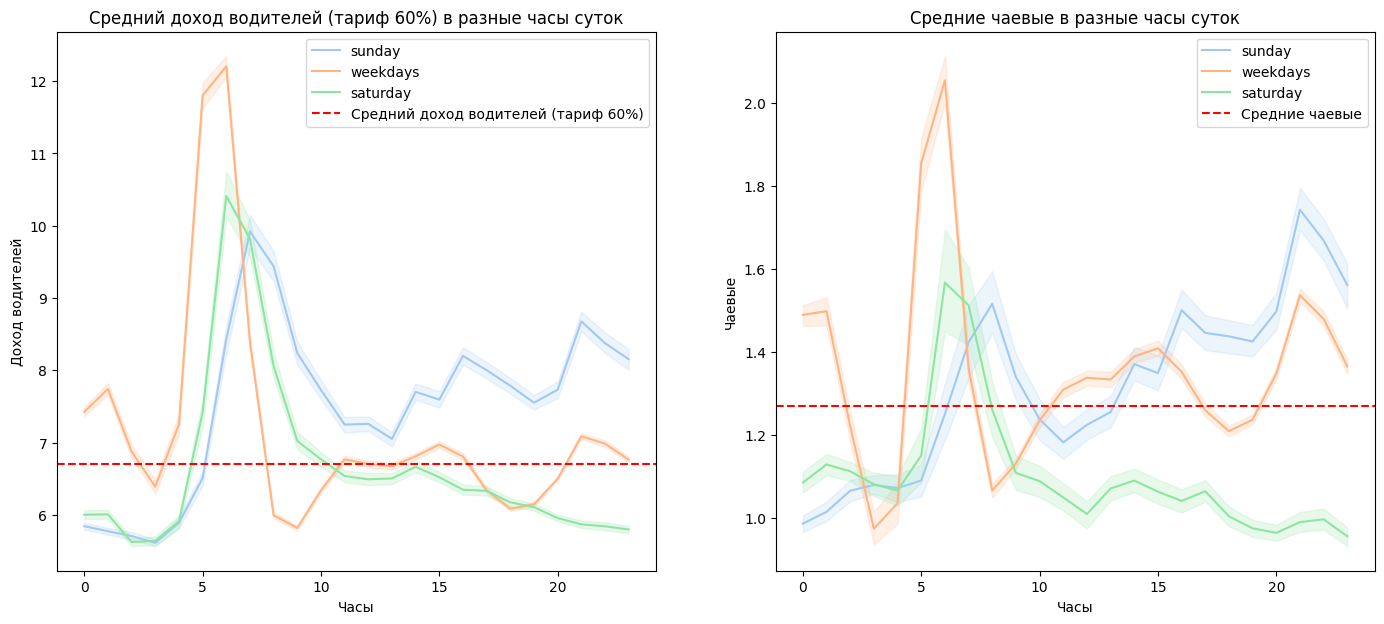

In [ ]:
#Визуализируем периоды, когда средний доход водителей (тариф 60%) и средние чаевые по часам и дням
#недели ниже общего среднего уровня.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 7)) #hue='weekends',

sns.lineplot(x='hour', y='60f', data=taxi_id_trip, hue='weekends', palette ="pastel", ax=ax1, \
             estimator='mean')
ax1.axhline(trip_fare_mean_, color='red',linestyle='--',label='Средний доход водителей (тариф 60%)')
ax1.legend()
ax1.set_title('Средний доход водителей (тариф 60%) в разные часы суток')
ax1.set_xlabel('Часы')
ax1.set_ylabel('Доход водителей')

sns.lineplot(x='hour', y='tips', data=taxi_id_trip, hue='weekends', palette ="pastel", ax=ax2, \
             estimator='mean')
ax2.axhline(trip_tips_mean, color='red',linestyle='--',label='Средние чаевые')
ax2.legend()
ax2.set_title('Средние чаевые в разные часы суток')
ax2.set_xlabel('Часы')
ax2.set_ylabel('Чаевые')

plt.show()

График чаевых по часам во многом повторяет график дохода водителей по часам только с более экстремальными значениями. Наблюдается более выраженный разрыв между уровнем чаевых с воскресенья по пятницу в период с 16 до 23 часов, чем за тот же период по уровню дохода водителей.

#### Определим критические периоды дефицита предложения

In [ ]:
#Сформируем таблицу со средним покрытием по часам и дням недели
estimated_coverage_trip = pd.pivot_table(data=taxi_id_trip,index='weekday',columns='hour',\
                                           values='estimated_coverage', \
                                           aggfunc='mean'). T
estimated_coverage_trip

weekday,1,2,3,4,5,6,7
hour,,,,,,,
0,0.73,0.72,0.72,0.73,0.74,0.76,0.75
1,0.74,0.75,0.70,0.76,0.73,0.76,0.76
2,0.73,0.74,0.72,0.73,0.75,0.77,0.76
3,0.73,0.69,0.77,0.75,0.72,0.75,0.77
4,0.73,0.73,0.73,0.73,0.75,0.75,0.76
5,0.72,0.74,0.72,0.73,0.74,0.72,0.76
6,0.79,0.75,0.65,0.73,0.73,0.71,0.73
7,0.76,0.79,0.81,0.74,0.78,0.74,0.75
8,0.77,0.77,0.76,0.77,0.78,0.75,0.77


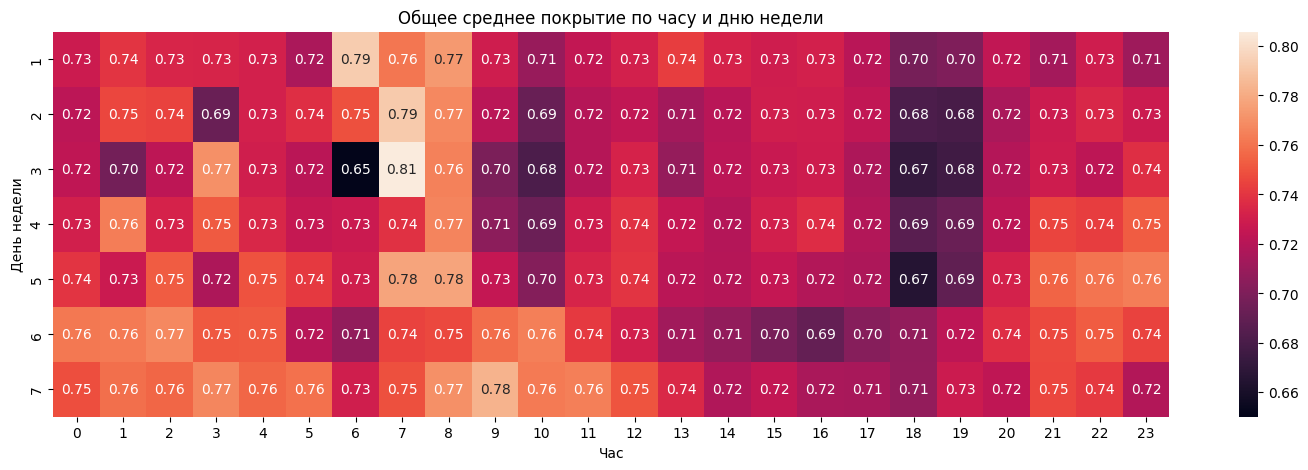

In [ ]:
#Визуализируем таблицу со средним покрытием по часам и дням недели
plt.figure(figsize=(18,5))
sns.heatmap(data = estimated_coverage_trip.T, \
            annot=True, fmt=".2f")
plt.title('Общее среднее покрытие по часу и дню недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

In [ ]:
#Посчитаем среднее покрытие за весь период
round(taxi_id_trip['estimated_coverage'].mean(),2)

0.73

Text(0, 0.5, 'Покрытие')

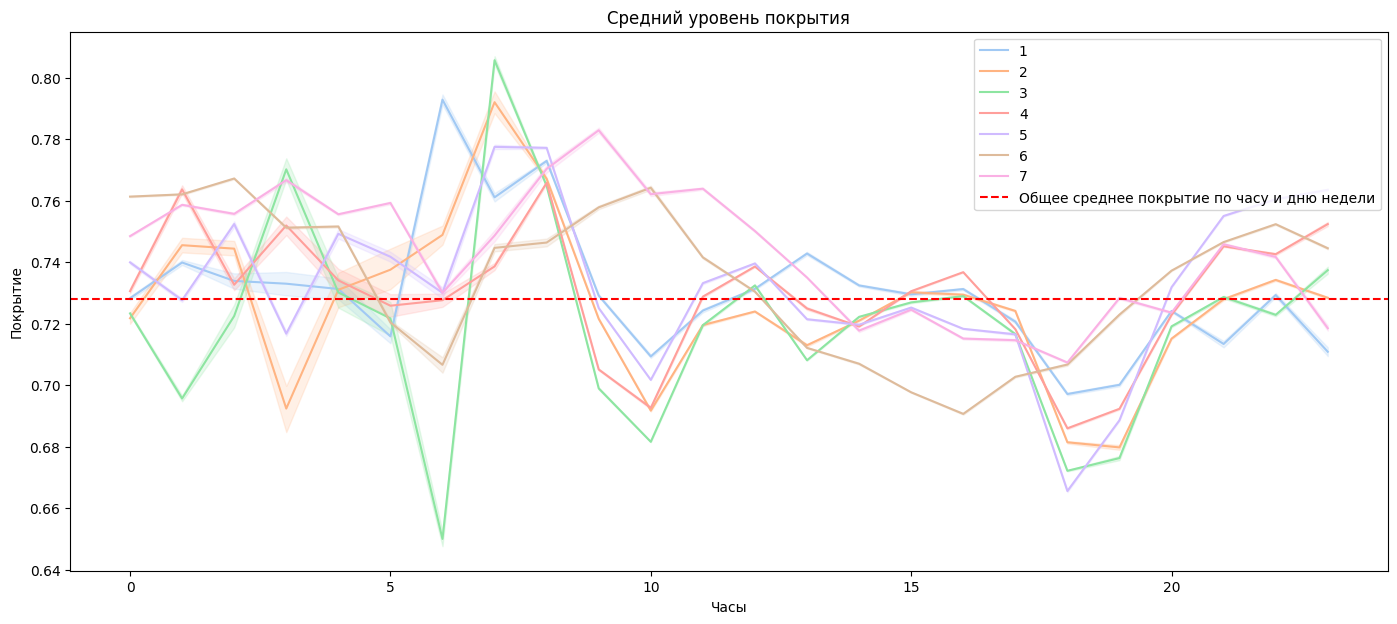

In [ ]:
#Визуализируем критические периоды дефицита предложения
fig = plt.subplots(figsize=(17, 7)) #hue='weekends',
sns.lineplot(x='hour', y='estimated_coverage', data=taxi_id_trip, hue='weekday', palette ="pastel",  \
             estimator='mean')
plt.axhline(taxi_id_trip['estimated_coverage'].mean(), color='red',linestyle='--',\
            label='Общее среднее покрытие по часу и дню недели')
plt.legend()
plt.title('Средний уровень покрытия')
plt.xlabel('Часы')
plt.ylabel('Покрытие')

Максимальный уровень покрытия составляет 0.8 в среду в 7 утра,  минимальный 0.65 в среду в 6 утра.
Критическими  периодами являются периоды:
- По вторникам в 2 часа ночи.
- По средам 1 час ночи и 6 часов утра.  
- В будние дни: 9 и 10 часов утра, 18 и 19 часов вечера.
- По субботам с 13 до 18 часов.

Общий средний уровень покрытия за весь период составив 0.73

#### Рассчитаем оптимальное число машин на линии для обеспечения нормального показателя покрытия

In [ ]:
#Выведем среднее количество такси по часам и дням недели
taxi_id_trip_coverage = pd.pivot_table(data=taxi_id_trip,index='weekday',columns='hour',\
                                         values='taxi_id_count',\
                                         aggfunc='mean'). T
taxi_id_trip_coverage

weekday,1,2,3,4,5,6,7
hour,,,,,,,
0,555.69,347.87,602.88,617.91,888.13,"1,336.59","1,562.86"
1,379.47,250.88,375.78,394.64,673.26,"1,238.34","1,455.26"
2,228.81,184.60,232.73,236.84,461.72,"1,094.55","1,171.98"
3,155.02,123.84,158.90,166.82,315.63,886.73,"1,096.45"
4,146.67,89.74,124.43,129.30,218.68,551.51,794.27
5,288.35,146.10,174.78,163.23,230.62,349.63,575.62
6,456.38,214.08,318.64,291.65,322.84,223.94,372.70
7,556.64,300.95,565.57,550.18,578.48,305.85,334.72
8,764.73,634.36,895.11,883.83,931.28,457.49,421.45


In [ ]:
#Посчитаем среднее количество такси по часам и дням, которое необходимо для удовлетворения спроса на 80%
optimal_taxi_count = round(taxi_id_trip_coverage/estimated_coverage_trip*0.8, 0)
optimal_taxi_count

weekday,1,2,3,4,5,6,7
hour,,,,,,,
0,610.00,386.00,667.00,677.00,960.00,"1,404.00","1,670.00"
1,410.00,269.00,432.00,413.00,740.00,"1,300.00","1,534.00"
2,249.00,198.00,258.00,259.00,491.00,"1,141.00","1,241.00"
3,169.00,143.00,165.00,177.00,352.00,944.00,"1,144.00"
4,160.00,98.00,136.00,141.00,233.00,587.00,841.00
5,322.00,158.00,194.00,180.00,249.00,388.00,606.00
6,460.00,229.00,392.00,321.00,354.00,254.00,408.00
7,585.00,304.00,562.00,596.00,595.00,329.00,358.00
8,791.00,662.00,936.00,923.00,959.00,490.00,438.00


В качестве оптимального покрытия я выбрала 80%, этот уровень, исходя из данных, выглядит возможным и досигаемым. Кроме того, позволит провайдеру сократить время ожидания клиентов, а значит избежать массового недовольства клиентов и снижения спроса.

<div class="alert alert-info">
   Готово. Аргументировать это оптимальным балансом сохранения прибыли (за счет сокращения доли дохода провайдера в счет увеличения доли водителей) и своей репутации не стала, так как нет конкретных расчетов. Их нам ещё только предстоит изчить.
</div>    

#### Определим	дефицит количества машин на линии (сколько нужно вывести машин дополнительно, чтобы достичь нормального покрытия)

In [ ]:
#Расчитаем нехватку такси по дням и часам для обеспечения покрытия на уровне 0.8
difference_taxi_count = round(optimal_taxi_count-taxi_id_trip_coverage, 0)
difference_taxi_count = difference_taxi_count[difference_taxi_count>=0]
difference_taxi_count

weekday,1,2,3,4,5,6,7
hour,,,,,,,
0,54.00,38.00,64.00,59.00,72.00,67.00,107.00
1,31.00,18.00,56.00,18.00,67.00,62.00,79.00
2,20.00,13.00,25.00,22.00,29.00,46.00,69.00
3,14.00,19.00,6.00,10.00,36.00,57.00,48.00
4,13.00,8.00,12.00,12.00,14.00,35.00,47.00
5,34.00,12.00,19.00,17.00,18.00,38.00,30.00
6,4.00,15.00,73.00,29.00,31.00,30.00,35.00
7,28.00,3.00,NaN,46.00,17.00,23.00,23.00
8,26.00,28.00,41.00,39.00,28.00,33.00,17.00


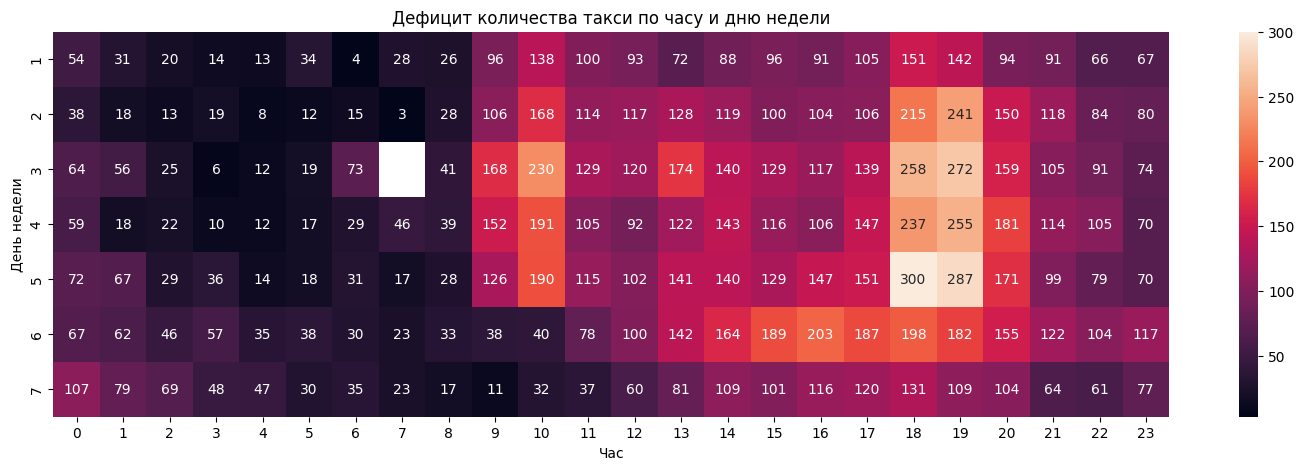

In [ ]:
#Визуализируем нехватку такси по дням и часам для обеспечения покрытия на уровне 0.8
plt.figure(figsize=(18,5))
sns.heatmap(difference_taxi_count. T, \
            annot=True, fmt=".0f")
plt.title('Дефицит количества такси по часу и дню недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

Больше всего машин не хватает в будние дни с 10 часов утра до 22 часов вечера. Пик нехватки приходтся с 18 до 20 часов вечера. В Субботу больше всего не хватает такси с 12 д 23 часов. В воскресенье с 14 до 20 часов вечера.

#### • Определим периоды, в которые меры стимулирования предложения услуг такси нужны и будут наиболее эффективны

In [ ]:
#Выведем средний доход провайдера по часам и дням недели
optimal_provider_fare = pd.pivot_table(data=taxi_id_trip,index='weekday',columns='hour',\
                                         values='provider_fare',\
                                         aggfunc='mean'). T
optimal_provider_fare

weekday,1,2,3,4,5,6,7
hour,,,,,,,
0,4.71,4.59,4.52,4.49,4.48,4.40,4.41
1,4.83,4.82,4.60,4.59,4.52,4.44,4.43
2,4.73,4.59,4.47,4.49,4.49,4.42,4.44
3,4.53,4.54,4.38,4.38,4.47,4.44,4.43
4,4.50,4.62,4.46,4.37,4.40,4.39,4.41
5,4.73,4.79,4.75,4.70,4.65,4.48,4.45
6,4.81,4.77,4.85,4.78,4.75,4.73,4.63
7,4.64,4.61,4.55,4.56,4.55,4.75,4.71
8,4.43,4.45,4.40,4.42,4.39,4.64,4.70


In [ ]:
#Посчитаем средний доход провайдера по часам и дням, который недополучен, если бы спрос был удовлетворен на 80%
sum_provider_fare = round(optimal_provider_fare*difference_taxi_count, 0)
sum_provider_fare

weekday,1,2,3,4,5,6,7
hour,,,,,,,
0,254.00,174.00,289.00,265.00,323.00,295.00,472.00
1,150.00,87.00,258.00,83.00,303.00,275.00,350.00
2,95.00,60.00,112.00,99.00,130.00,203.00,306.00
3,63.00,86.00,26.00,44.00,161.00,253.00,213.00
4,58.00,37.00,54.00,52.00,62.00,154.00,207.00
5,161.00,57.00,90.00,80.00,84.00,170.00,133.00
6,19.00,72.00,354.00,139.00,147.00,142.00,162.00
7,130.00,14.00,NaN,210.00,77.00,109.00,108.00
8,115.00,125.00,181.00,172.00,123.00,153.00,80.00


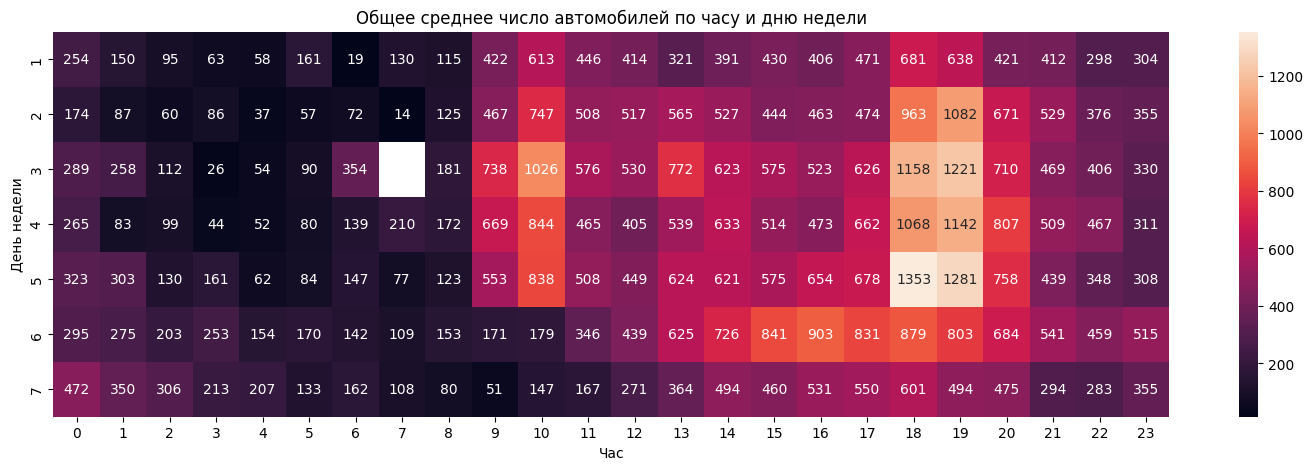

In [ ]:
#Визуализируем среднюю сумму недополученной провайдером прибыли
plt.figure(figsize=(18,5))
sns.heatmap(sum_provider_fare. T, \
            annot=True, fmt=".0f")
plt.title('Общее среднее число автомобилей по часу и дню недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

Максимальный объем недополученной прибыли из-за нехватки автомобилей наблюдается: в будние дни с 9 часов утра до 22 часов вечера. Пики недополученной прибыли приходятся на период с 18 до 20 часов вечера со вторника по пятницу и на 14 - 18 часов в субботу. В воскресенье больше всего недополученной прибыли приходятся на период с 14 до 20 часов вечера.

Периоды с наибольшим объемом недополученной прибыли из-за нехватки автомобилей - это периоды в которые провайдеру наиболее актуально стимулировать водителей выходить на линию и периоды, в которые количество пассажиров не смогли воспользоваться услугами такси наибольшее, а значит вызывает наиболшее недовольство.

#### • Определим объём недополученной общей выручки из-за низкого предложения

In [ ]:
sum_pro = (taxi_id_trip['trip_total']/taxi_id_trip['estimated_coverage']*0.8\
 - taxi_id_trip['trip_total']).sum().round(0)
print('Объем недополученной общей выручки из-за низкого предложения, исходя из покрытия 0.8, составил -', \
      sum_pro, '$,',  'что  соответствует доле - ', \
      round(sum_pro/taxi_id_trip['trip_total'].sum()*100, 2), '%')

Объем недополученной общей выручки из-за низкого предложения, исходя из покрытия 0.8, составил - 2319454.0 $, что  соответствует доле -  10.07 %


#### • Определим недополученной выручки провайдера из-за низкого предложения

In [ ]:
sum_total = (taxi_id_trip['provider_fare']/taxi_id_trip['estimated_coverage']*0.8\
 - taxi_id_trip['provider_fare']).sum().round(0)
print('Объем недополученной провайдером прибыли, исходя из покрытия 0.8, составил -', sum_total, '$,', \
     'что соответствует доле - ', round(sum_total/taxi_id_trip['provider_fare'].sum()*100, 2), '%')

Объем недополученной провайдером прибыли, исходя из покрытия 0.8, составил - 800828.0 $, что соответствует доле -  10.14 %


#### Общий вывод:





Среднее покрытие составляет 73%, наибольшее 81%, минимальное 65%.
Больше всего машин не хватает в будние дни с 9 часов утра до 23 часов вечера.
Пик нехватки приходится с 18 до 20 часов вечера в будние дни.
В субботу наибольшая нехватка машин с 13 до 23 часов.
В воскресенье с 14 до 20 часов вечера.
Объем недополученной общей выручки из-за низкого предложения:  23194542, что соответствует доле -      10.07 %. Объем недополученной провайдером прибыли, исходя из покрытия 0.8, составил - 800828, что соответствует доле -      10.14 %

#### Рекомендации бизнесу:    
Исходя из анализа данных, наблюдается потенциал увеличения прибыли порядка 10%. Для этого необходимо простимулировать водителей выходить на линии в период возрастяющего спроса, например, путем увеличения тарифа причитающегося водителю в эти периоды, а так же путем дополниительных push-уведомлений о возросшем спросе на услуги такси.